In [101]:
# import statements
import requests
import json
import statistics
from datetime import date

# import data libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from scipy.stats import pearsonr, spearmanr

# import data visualizations libraries
import matplotlib.pyplot as plt
# changes


In [102]:
# static vairables
BASE_URL = "https://api.covidtracking.com/"
HISTORIC_US_URL = BASE_URL+"{}".format("v2/us/daily.json")
CURRENT_US_URL = BASE_URL+"{}".format("v1/us/current.json")
def HISTORIC_STATE_URL(state):
  # print(BASE_URL + "v1/states/{}/daily.json".format(state))
  return BASE_URL + "v1/states/{}/daily.json".format(state)
STATES = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

---
## **This Section focuses on the Current state of COVID-19 disease in the United States.**
---

In [103]:
# current state of COVID 19 in the United States request
response = requests.get(CURRENT_US_URL)
response.status_code
data = response.json()[0]
# print(json.dumps(data, indent=4, sort_keys=True))

In [104]:
print("Today: {}".format(date.today()))
print("Death Increase: {}".format(data['deathIncrease']))
print("Hospitalized Increase: {}".format(data['hospitalizedIncrease']))
print("Positive Increase: {}".format(data['positiveIncrease']))
print("Negative Increase: {}".format(data['negativeIncrease']))
print("Test Result Increase: {}".format(data['totalTestResultsIncrease']))

Today: 2021-10-01
Death Increase: 842
Hospitalized Increase: 726
Positive Increase: 41835
Negative Increase: 131835
Test Result Increase: 1170059


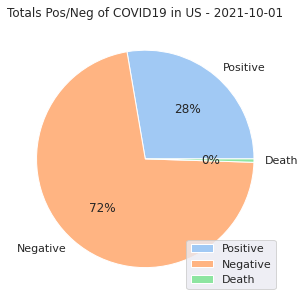

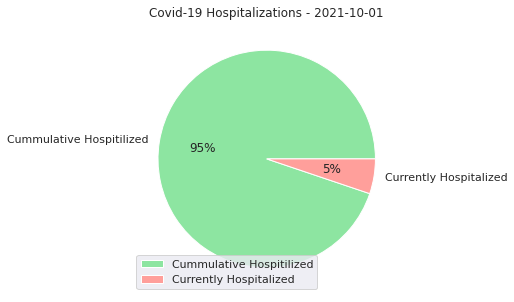

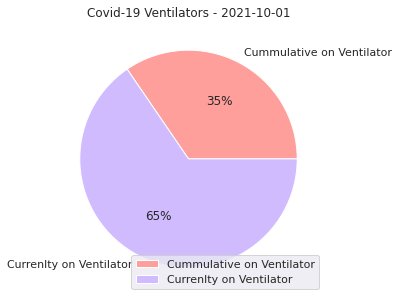

In [105]:
currentData = [
      data['positive'], data['negative'], data['death'], data['pending'], data['hospitalizedCumulative'], data['hospitalizedCurrently'], data['onVentilatorCumulative'], data['onVentilatorCumulative']
]
labels = [
      "Positive", "Negative", "Death", "Pending", "Cummulative Hospitilized", "Currently Hospitalized", "Cummulative on Ventilator", "Currenlty on Ventilator"
]
# plot simple pie graph
colors = sns.color_palette('pastel')[0:5]
sns.set(
    rc={'figure.figsize':(15,5)}
    )
plt.title("Totals Pos/Neg of COVID19 in US - {}".format(date.today()))
plt.pie(
    [data['positive'], data['negative'], data['death']], 
    labels = ["Positive", "Negative", "Death"], 
    colors = colors, 
    autopct='%.0f%%'
    )
plt.legend(loc="lower right")
plt.show()

# Hospitilizations
colors = sns.color_palette('pastel')[2:4]
sns.set(
    rc={'figure.figsize':(15,5)}
    )
plt.title("Covid-19 Hospitalizations - {}".format(date.today()))

plt.pie(
    [data['hospitalizedCumulative'] - data['hospitalizedCurrently'], 
     data['hospitalizedCurrently']], 
    labels = ["Cummulative Hospitilized", 
              "Currently Hospitalized"],
    colors = colors, 
    autopct='%.0f%%'
    )
plt.legend(loc="lower left")
plt.show()

# Ventilators
colors = sns.color_palette('pastel')[3:5]
sns.set(
    rc={'figure.figsize':(15,5)}
    )
plt.title("Covid-19 Ventilators - {}".format(date.today()))
plt.pie(
    [data['onVentilatorCumulative'] - data['onVentilatorCurrently'], 
     data['onVentilatorCurrently']], 
    labels = ["Cummulative on Ventilator", 
              "Currenlty on Ventilator"], 
    colors = colors, 
    autopct='%.0f%%'
    )
plt.legend(loc="lower right")

---
## **This Section focuses on the growth of COVID-19 disease in the United States.**
---

In [106]:
# get request for Historical data & put into dataframe
response = requests.get(HISTORIC_US_URL)
response.status_code
data = response.json()['data']
df = pd.DataFrame(data)
df

,date,states,cases,testing,outcomes
0,2021-03-07,56,"{'total': {'value': 28756489, 'calculated': {'...","{'total': {'value': 363825123, 'calculated': {...",{'hospitalized': {'currently': {'value': 40199...
1,2021-03-06,56,"{'total': {'value': 28714654, 'calculated': {'...","{'total': {'value': 362655064, 'calculated': {...",{'hospitalized': {'currently': {'value': 41401...
2,2021-03-05,56,"{'total': {'value': 28654639, 'calculated': {'...","{'total': {'value': 361224072, 'calculated': {...",{'hospitalized': {'currently': {'value': 42541...
3,2021-03-04,56,"{'total': {'value': 28585852, 'calculated': {'...","{'total': {'value': 359479655, 'calculated': {...",{'hospitalized': {'currently': {'value': 44172...
4,2021-03-03,56,"{'total': {'value': 28520365, 'calculated': {'...","{'total': {'value': 357888671, 'calculated': {...",{'hospitalized': {'currently': {'value': 45462...
...,...,...,...,...,...
415,2020-01-17,1,"{'total': {'value': 0, 'calculated': {'populat...","{'total': {'value': 0, 'calculated': {'populat...","{'hospitalized': {'currently': {'value': None,..."
416,2020-01-16,1,"{'total': {'value': 0, 'calculated': {'populat...","{'total': {'value': 0, 'calculated': {'populat...","{'hospitalized': {'currently': {'value': None,..."
417,2020-01-15,1,"{'total': {'value': 0, 'calculated': {'populat...","{'total': {'value': 0, 'calculated': {'populat...","{'hospitalized': {'currently': {'value': None,..."
418,2020-01-14,1,"{'total': {'value': 0, 'calculated': {'populat...","{'total': {'value': 0, 'calculated': {'populat...","{'hospitalized': {'currently': {'value': None,..."


In [107]:
print(df['cases'][0]['total'])
print(df['testing'][0]['total'])
print(df['outcomes'][0]['hospitalized'])
# format data into lists for matplotlib - historical cases
datesList = df['date'].to_list()
datesList.reverse()
totalCasesList = [df['cases'][i]['total']['value'] for i in range(len(datesList))]
totalCasesList.reverse()
dfTotalCases = pd.DataFrame(
    data={
        "Total Cases": totalCasesList
    },
    index=datesList
)
dfTotalCases['Percent Change'] = dfTotalCases['Total Cases'].pct_change()
dfTotalCases['Percent Changes'] = dfTotalCases['Percent Change'].replace(np.nan, 0)
dfTotalCases['Percent Change'] = dfTotalCases['Percent Change'].replace(np.inf, 0)

# calculate simple moving averages
dfTotalCases["7 sma"] = dfTotalCases['Total Cases'].rolling(window=7).mean()
dfTotalCases["20 sma"] = dfTotalCases['Total Cases'].rolling(window=20).mean()
dfTotalCases["50 sma"] = dfTotalCases['Total Cases'].rolling(window=50).mean()
dfTotalCases["100 sma"] = dfTotalCases['Total Cases'].rolling(window=100).mean()

# calculate expontetial moving averages
dfTotalCases["7 ema"] = dfTotalCases['Total Cases'].ewm(
    span=7,min_periods=0,adjust=False,ignore_na=False
    ).mean()
dfTotalCases["20 ema"] = dfTotalCases['Total Cases'].ewm(
    span=20,min_periods=0,adjust=False,ignore_na=False
    ).mean()
dfTotalCases["50 ema"] = dfTotalCases['Total Cases'].ewm(
    span=50,min_periods=0,adjust=False,ignore_na=False
    ).mean()
dfTotalCases["100 ema"] = dfTotalCases['Total Cases'].ewm(
    span=100,min_periods=0,adjust=False,ignore_na=False
    ).mean()

dfTotalCases

{'value': 28756489, 'calculated': {'population_percent': 8.6932, 'change_from_prior_day': 41835, 'seven_day_change_percent': 1.4}}
{'value': 363825123, 'calculated': {'population_percent': 109.9858, 'change_from_prior_day': 1170059, 'seven_day_change_percent': 2.8}}
{'currently': {'value': 40199, 'calculated': {'population_percent': 0.0122, 'change_from_prior_day': -1202, 'seven_day_change_percent': -15.1, 'seven_day_average': 43843}}, 'in_icu': {'currently': {'value': 8134, 'calculated': {'population_percent': 0.0025, 'change_from_prior_day': -275, 'seven_day_change_percent': -17, 'seven_day_average': 8938}}}, 'on_ventilator': {'currently': {'value': 2802, 'calculated': {'population_percent': 0.0008, 'change_from_prior_day': -9, 'seven_day_change_percent': -13.7, 'seven_day_average': 2987}}}}


,Total Cases,Percent Change,Percent Changes,7 sma,20 sma,50 sma,100 sma,7 ema,20 ema,50 ema,100 ema
2020-01-13,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-15,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-16,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-17,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-03,28520365.0,0.002349,0.002349,2.834251e+07,27910988.25,26360388.54,21883653.48,2.833475e+07,2.782544e+07,2.590465e+07,2.227979e+07
2021-03-04,28585852.0,0.002296,0.002296,2.840466e+07,27976946.35,26474347.28,22043659.80,2.839753e+07,2.789786e+07,2.600980e+07,2.240466e+07
2021-03-05,28654639.0,0.002406,0.002406,2.846596e+07,28041811.70,26585169.44,22202469.03,2.846180e+07,2.796994e+07,2.611352e+07,2.252842e+07
2021-03-06,28714654.0,0.002094,0.002094,2.852564e+07,28106069.60,26692262.82,22360580.77,2.852502e+07,2.804086e+07,2.621552e+07,2.265092e+07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


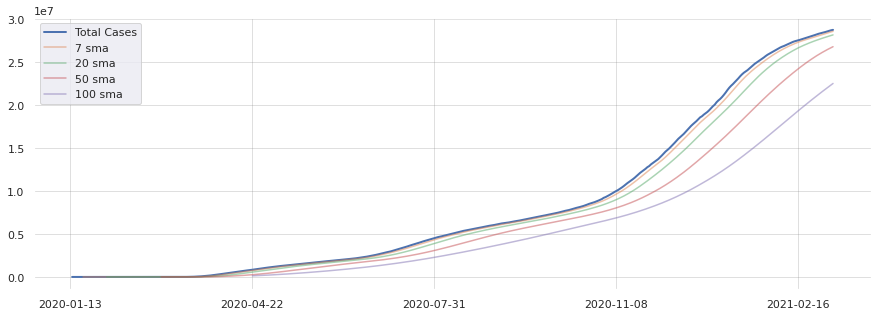

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


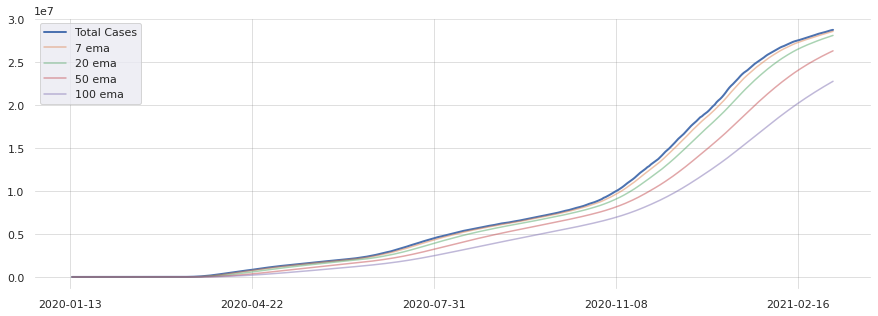

In [108]:
# plot Total Cases and SMAs data
alpha = 0.5
linewidth = 2
plt.plot(    
    figsize=(12,5),
    title="Total Cases & SMAs",
    ylabel="Total Cases (10 mil)",
    xlabel="Date"
    )
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(
    color='grey', 
    linestyle='-', 
    linewidth=1, 
    alpha=alpha-0.25
  )
dfTotalCases['Total Cases'].plot(legend=True, linewidth=linewidth)
dfTotalCases['7 sma'].plot(legend=True, alpha=alpha)
dfTotalCases['20 sma'].plot(legend=True, alpha=alpha)
dfTotalCases['50 sma'].plot(legend=True, alpha=alpha)
dfTotalCases['100 sma'].plot(legend=True, alpha=alpha)
plt.show()

# plot Total Cases and EMAs data
plt.plot(    
    figsize=(12,5),
    title="Total Cases & EMAs",
    ylabel="Total Cases (10 mil)",
    xlabel="Date"
    )
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(
    color='grey', 
    linestyle='-', 
    linewidth=1, 
    alpha=alpha-0.25
  )
dfTotalCases['Total Cases'].plot(legend=True, linewidth=linewidth)
dfTotalCases['7 ema'].plot(legend=True, alpha=alpha)
dfTotalCases['20 ema'].plot(legend=True, alpha=alpha)
dfTotalCases['50 ema'].plot(legend=True, alpha=alpha)
dfTotalCases['100 ema'].plot(legend=True, alpha=alpha)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


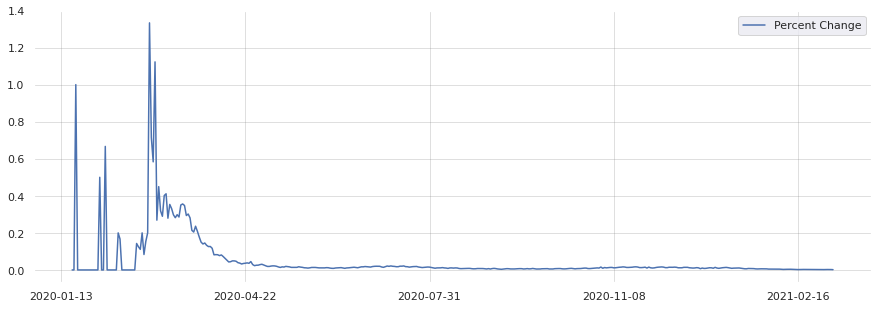

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


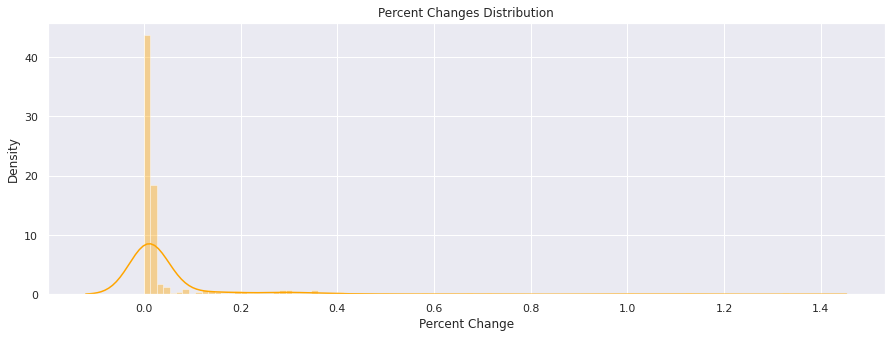

In [109]:
# plot percent changes
plt.plot(    
    figsize=(12,5),
    title="Total Cases Percent Changes",
    ylabel="Total Cases (10 mil)",
    xlabel="Date"
    )
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(
    color='grey', 
    linestyle='-', 
    linewidth=1, 
    alpha=alpha-0.25
  )
dfTotalCases['Percent Change'].plot(legend=True)
plt.show()

# plot percent changes distribution 
sns.distplot(
    dfTotalCases['Percent Change'], 
    bins=100, color='orange'
    ).set(
        title="Percent Changes Distribution"
        )
sns.set(rc={'figure.figsize':(15,5)})

In [110]:
# get type of growth in COVID 19 Cases


The first graph represents the actual values 

In [111]:
# format data for changes per day 
casesChangeList = [df['cases'][i]['total']['calculated']['change_from_prior_day'] for i in range(len(datesList))]
casesChangeList.reverse()
dfCasesChange = pd.DataFrame(
    data={
        "Changes in Cases": casesChangeList
    },
    index=datesList
)

In [112]:
# percent changes data
dfCasesChange['Percent Change'] = dfCasesChange['Changes in Cases'].pct_change()

In [113]:
# format data for rolling standard devition
dfCasesChange['Rolling STD'] = dfCasesChange['Changes in Cases'].rolling(3).std()
dfCasesChange

,Changes in Cases,Percent Change,Rolling STD
2020-01-13,NaN,NaN,NaN
2020-01-14,NaN,NaN,NaN
2020-01-15,0.0,NaN,NaN
2020-01-16,0.0,NaN,NaN
2020-01-17,0.0,NaN,0.000000
...,...,...,...
2021-03-03,66836.0,0.232045,9554.158048
2021-03-04,65487.0,-0.020184,6911.254903
2021-03-05,68787.0,0.050392,1659.126377
2021-03-06,60015.0,-0.127524,4430.590028


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


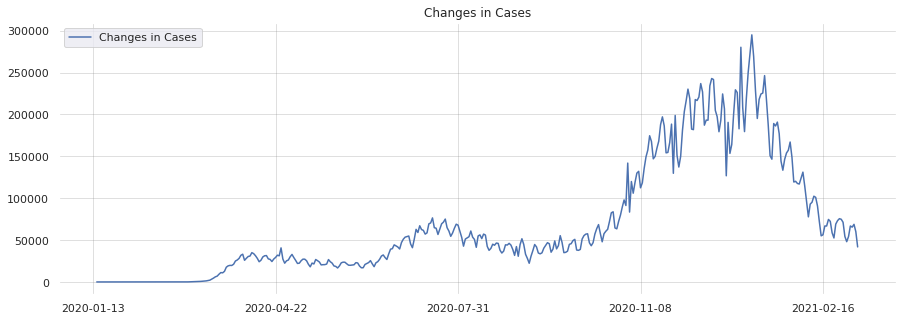

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


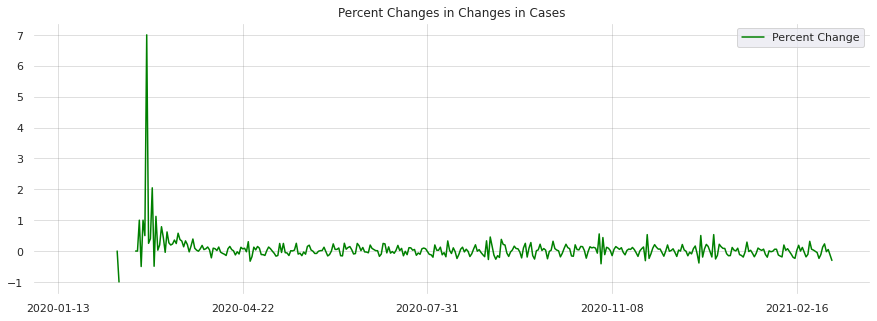

In [114]:
# plot data
dfCasesChange['Changes in Cases'].plot(
    figsize=(15,5),
    legend=True,
    title="Changes in Cases"
)
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(
    color='grey', 
    linestyle='-', 
    linewidth=1, 
    alpha=alpha-0.25
  )
plt.show()

# percent changes
dfCasesChange['Percent Change'].plot(
    figsize=(15,5),
    legend=True,
    title="Percent Changes in Changes in Cases",
    color="green"
)
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(
    color='grey', 
    linestyle='-', 
    linewidth=1, 
    alpha=alpha-0.25
  )
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


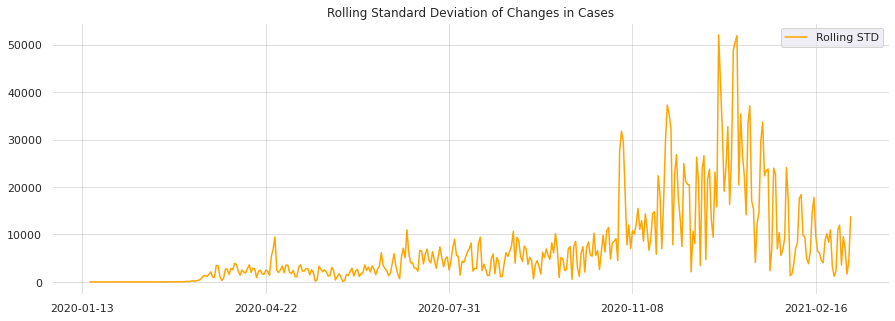

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


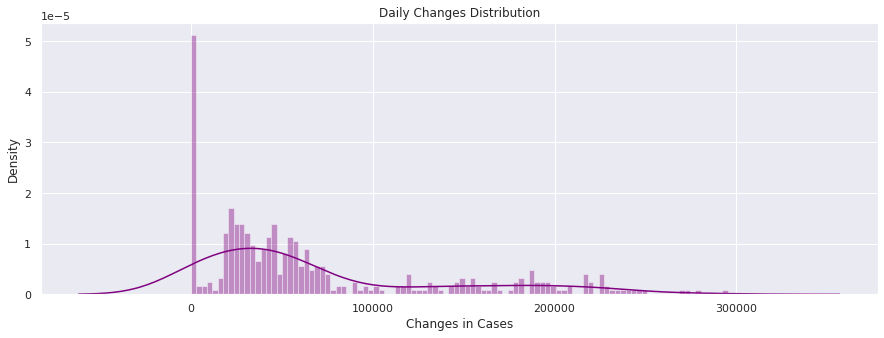

In [115]:
# rolling std
dfCasesChange['Rolling STD'].plot(
    figsize=(15,5),
    legend=True,
    title="Rolling Standard Deviation of Changes in Cases",
    color="orange"
)
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(
    color='grey', 
    linestyle='-', 
    linewidth=1, 
    alpha=alpha-0.25
  )
plt.show()

# plot distribution graph of daily changes
sns.distplot(
    dfCasesChange['Changes in Cases'], 
    bins=100, color='purple'
    ).set(
        title="Daily Changes Distribution"
        )
sns.set(rc={'figure.figsize':(15,5)})

**This section focuses on statistical analysis of the COVID-19 Disease**

---
## **This section focuses on statistical analysis of the COVID-19 Disease.**
---

---
## **This section focuses on statistical correlation of the COVID 19 disease between states in the United Satates.**
---

In [116]:
# State input for correlation and covariance stsatistics
STATE_INPUT = "ca"

In [117]:
# get request for data & put into dataframe
def getDataState(state):
  response = requests.get(HISTORIC_STATE_URL(state))
  # print(response.status_code)
  dataResponse = response.json()
  data = {
      "date": [],
      "total": [],

  }
  for day in dataResponse:
    data['date'].append(day['date'])
    data['total'].append(day['total'])
  data['date'].reverse()
  data['total'].reverse()
  df = pd.DataFrame(data)
  return df

dfInput = getDataState(STATE_INPUT)
print(dfInput)

         date    total
0    20200304      515
1    20200305      515
2    20200306      522
3    20200307      531
4    20200308      550
..        ...      ...
364  20210303  3484963
365  20210304  3488467
366  20210305  3493126
367  20210306  3497578
368  20210307  3501394

[369 rows x 2 columns]


In [118]:
dfInput['Percent Changes Cases'] = dfInput['total'].pct_change()
dfInput['Percent Changes Cases'] = dfInput['Percent Changes Cases'].replace(np.nan, 0)
dfInput['Percent Changes Cases'] = dfInput['Percent Changes Cases'].replace(np.inf, 0)
dfInput

,date,total,Percent Changes Cases
0,20200304,515,0.000000
1,20200305,515,0.000000
2,20200306,522,0.013592
3,20200307,531,0.017241
4,20200308,550,0.035782
...,...,...,...
364,20210303,3484963,0.000963
365,20210304,3488467,0.001005
366,20210305,3493126,0.001336
367,20210306,3497578,0.001275


In [119]:
# format percent changes into numpy array

== Correlation Statistics with ca ==


== Current State AL ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.015436669982665352
ca and AL have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5744125086755706
ca and AL have a MODERATE POS/NEGE correlation



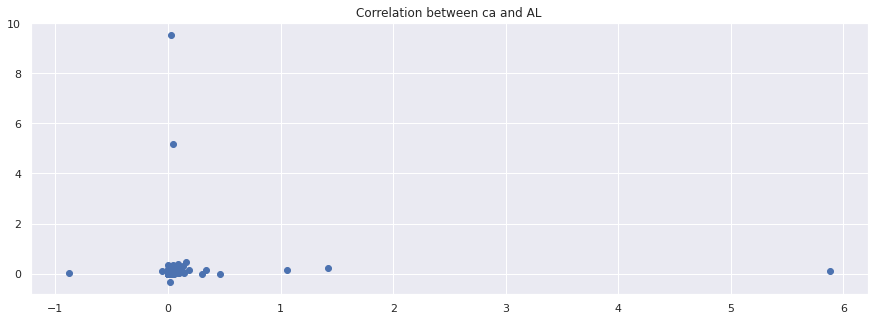



== Current State AK ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.052012311132058044
ca and AK have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.3044047404770155
ca and AK have a LOW POS/NEG correlation



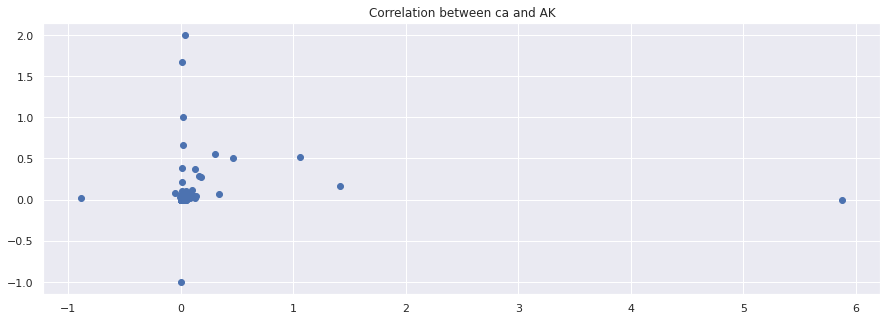



== Current State AZ ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.01802059464114835
ca and AZ have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6921705887701884
ca and AZ have a MODERATE POS/NEGE correlation



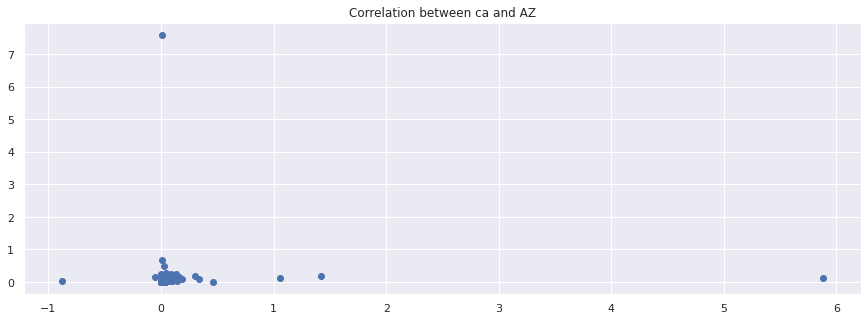



== Current State AR ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.14807683348248374
ca and AR have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.43458498871597584
ca and AR have a LOW POS/NEG correlation



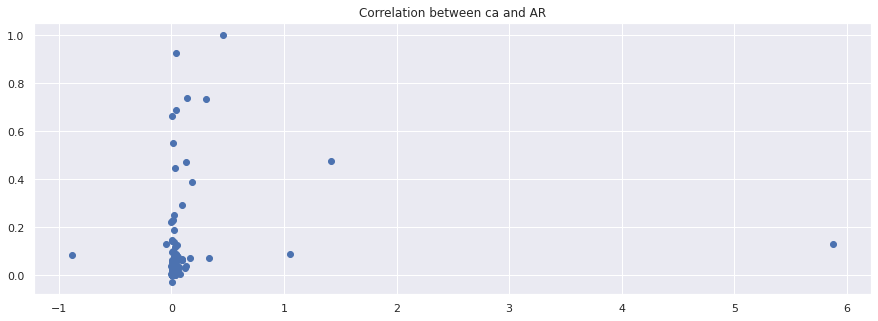



== Current State CA ==

== Pearson Correlation Analysis ==

Pearson Correlation: 1.0
ca and CA have a STRONG POSITVE correlation


== Spearman Correlation Analysis ==

Spearman Correlation: 0.9999999999999999
ca and CA have a HIGH POS/NEG correlation



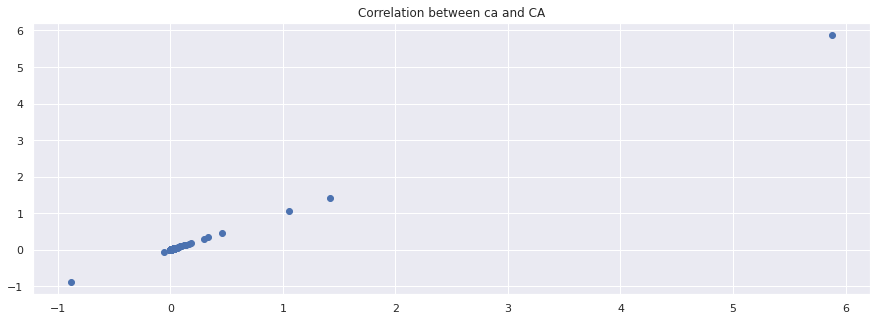



== Current State CO ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.40029673620847683
ca and CO have a MODERATE POSTIVE correlation


== Spearman Correlation Analysis ==

Spearman Correlation: 0.6019389922355868
ca and CO have a MODERATE POS/NEGE correlation



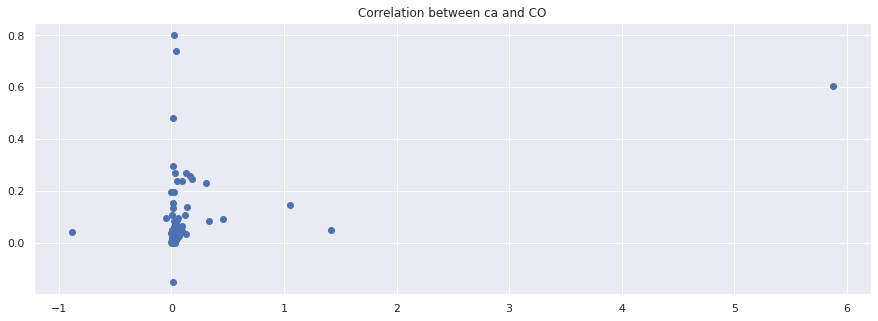



== Current State CT ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.1696093651258052
ca and CT have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.20510415494983797
ca and CT have a NEGLIGIBLE correlation



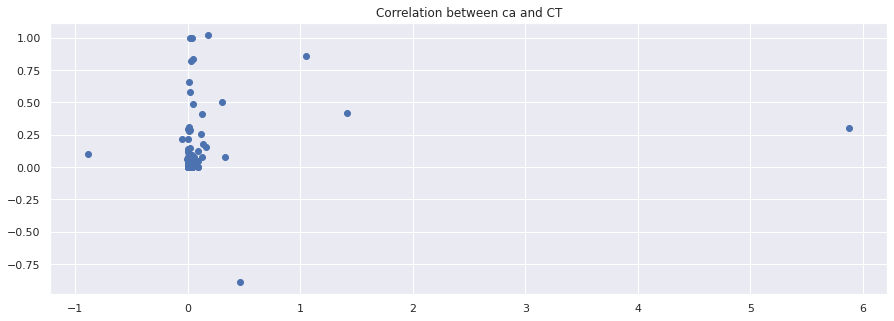



== Current State DC ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.021523812745588313
ca and DC have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5495097748266468
ca and DC have a MODERATE POS/NEGE correlation



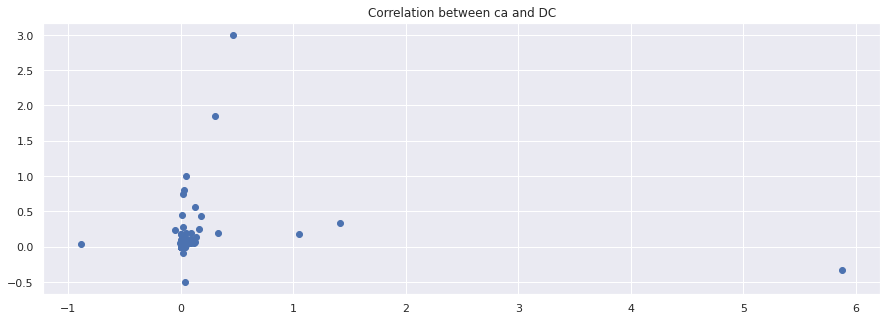



== Current State DE ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.010867041576368374
ca and DE have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5650005777312787
ca and DE have a MODERATE POS/NEGE correlation



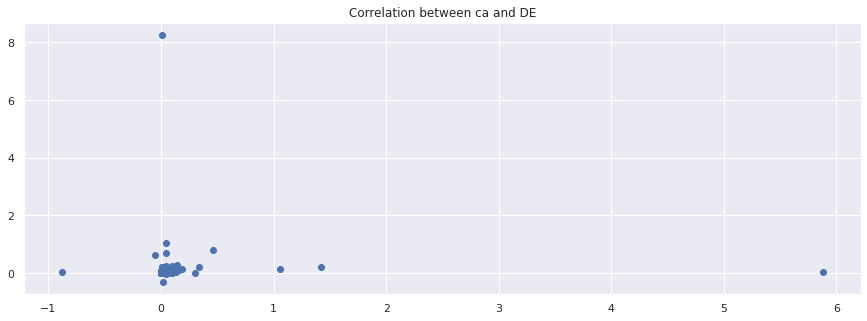



== Current State FL ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.0892356077452792
ca and FL have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.7383616949672486
ca and FL have a HIGH POS/NEG correlation



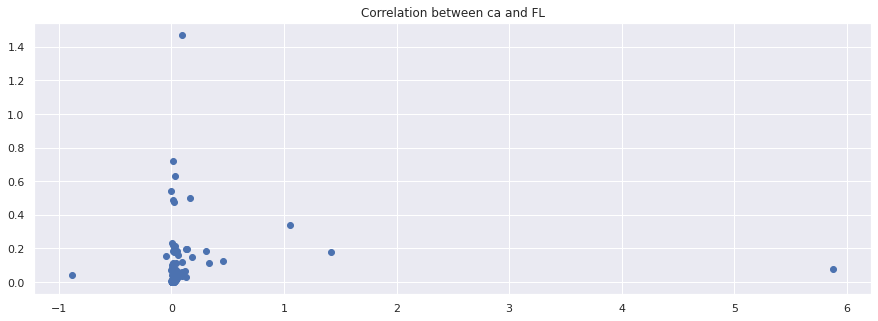



== Current State GA ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.13719799151640577
ca and GA have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.7842495430628464
ca and GA have a HIGH POS/NEG correlation



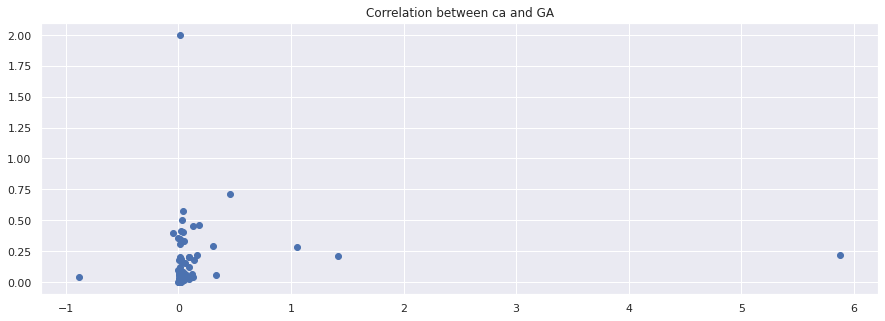



== Current State HI ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.2886510048838354
ca and HI have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.4706658683556152
ca and HI have a LOW POS/NEG correlation



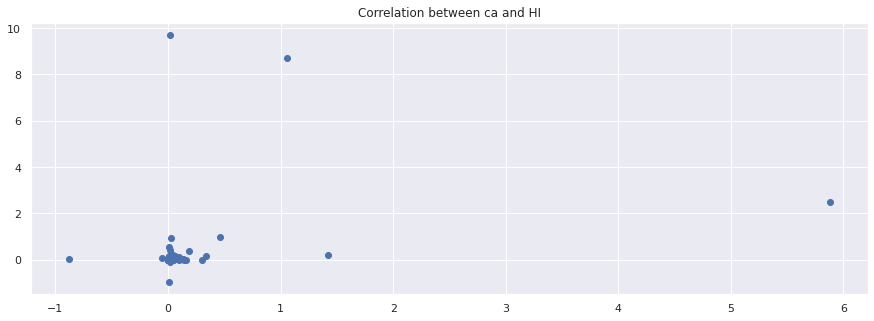



== Current State ID ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.3572375648669768
ca and ID have a MODERATE POSTIVE correlation


== Spearman Correlation Analysis ==

Spearman Correlation: 0.5220776215250077
ca and ID have a MODERATE POS/NEGE correlation



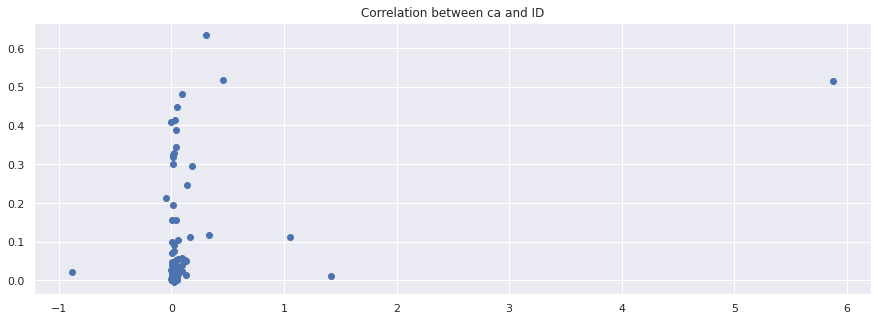



== Current State IL ==

== Pearson Correlation Analysis ==

Pearson Correlation: -0.25809056435103955
ca and IL have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.3786569124728652
ca and IL have a LOW POS/NEG correlation



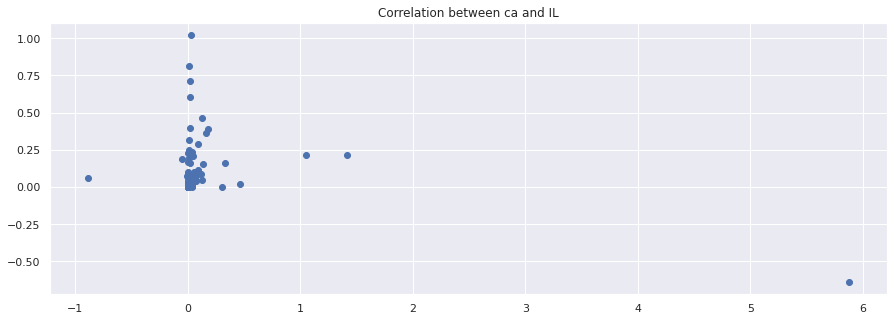



== Current State IN ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.011645149583031596
ca and IN have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.65559052162676
ca and IN have a MODERATE POS/NEGE correlation



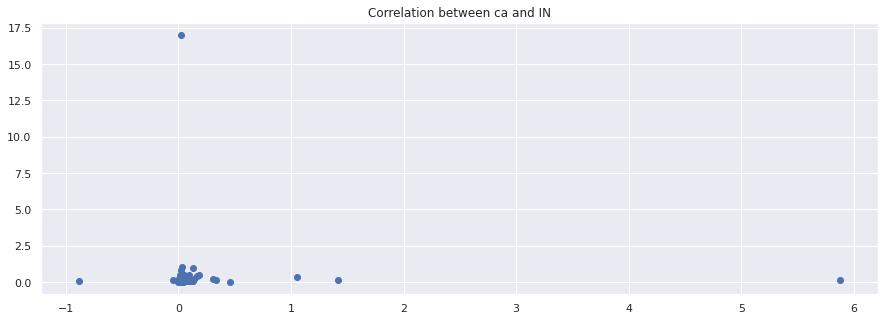



== Current State IA ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.07517068690806744
ca and IA have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5847484006280809
ca and IA have a MODERATE POS/NEGE correlation



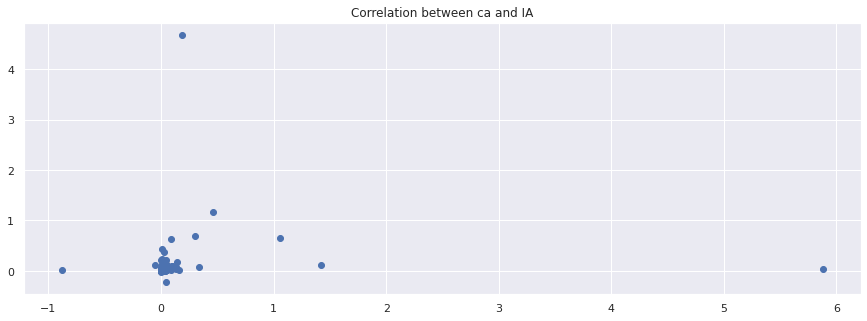



== Current State KS ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.045792856012961555
ca and KS have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.317979072588717
ca and KS have a LOW POS/NEG correlation



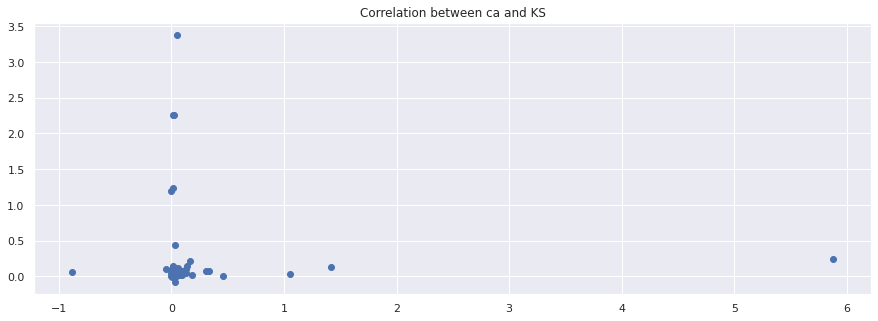



== Current State KY ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.16993798748508088
ca and KY have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.4574944893193472
ca and KY have a LOW POS/NEG correlation



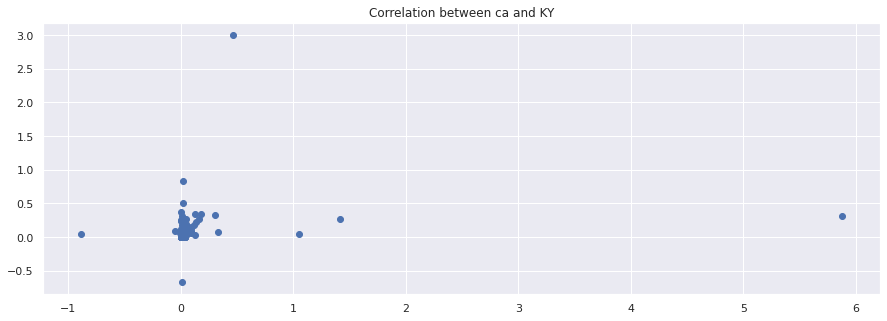



== Current State LA ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.14769802447564712
ca and LA have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5307257062327173
ca and LA have a MODERATE POS/NEGE correlation



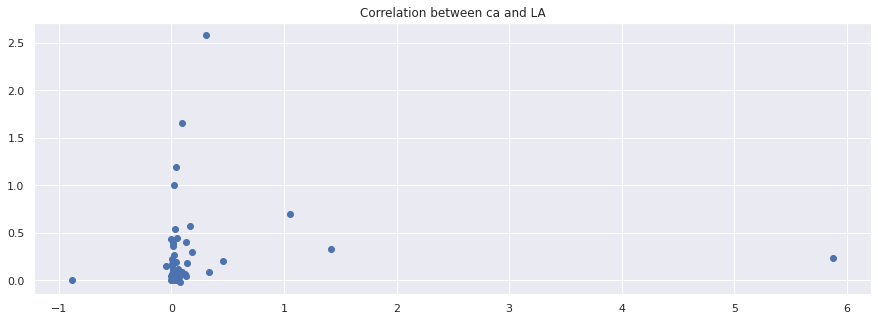



== Current State ME ==

== Pearson Correlation Analysis ==

Pearson Correlation: -0.02277069999199334
ca and ME have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.4384949074922345
ca and ME have a LOW POS/NEG correlation



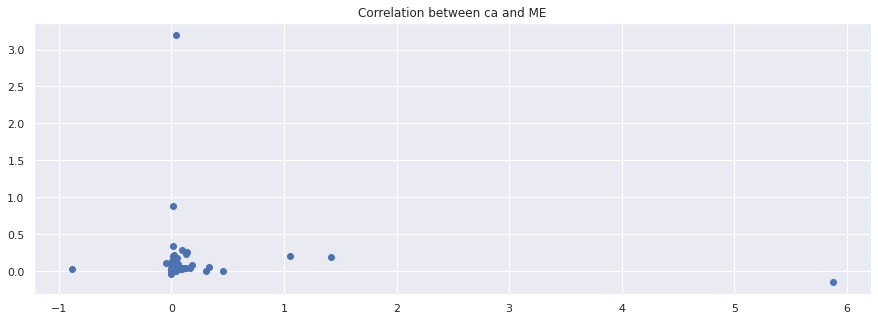



== Current State MD ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.025417238765280025
ca and MD have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.7026782299658987
ca and MD have a HIGH POS/NEG correlation



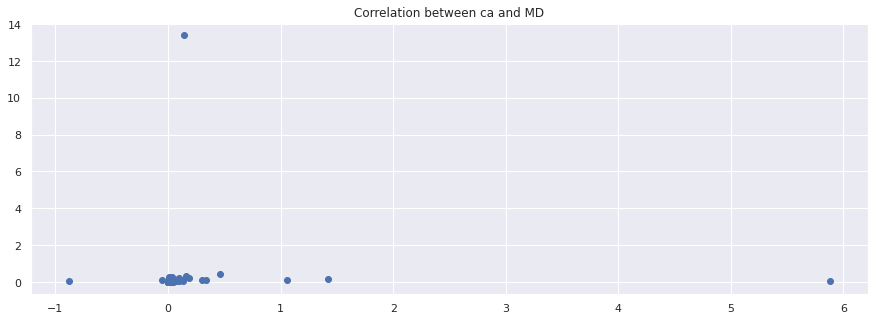



== Current State MA ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.08765795607634674
ca and MA have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5770811980532985
ca and MA have a MODERATE POS/NEGE correlation



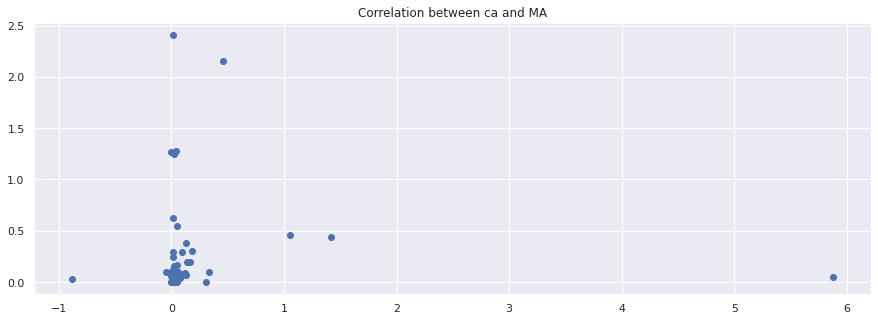



== Current State MI ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.3245768629034348
ca and MI have a MODERATE POSTIVE correlation


== Spearman Correlation Analysis ==

Spearman Correlation: 0.28551862641436826
ca and MI have a NEGLIGIBLE correlation



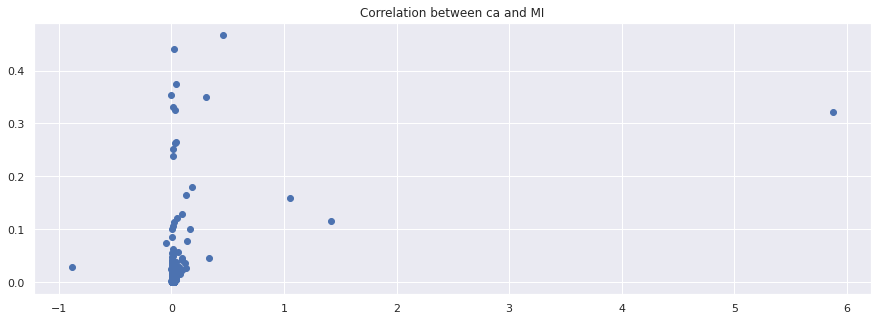



== Current State MN ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.29178493193480914
ca and MN have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6077409939450895
ca and MN have a MODERATE POS/NEGE correlation



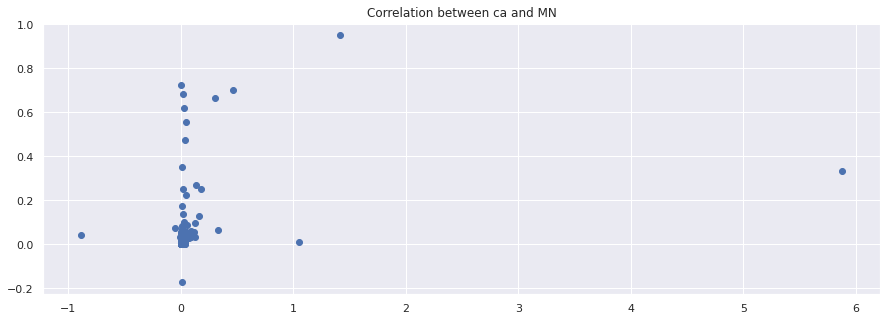



== Current State MS ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.5906223171490005
ca and MS have a MODERATE POSTIVE correlation


== Spearman Correlation Analysis ==

Spearman Correlation: 0.4270234120683802
ca and MS have a LOW POS/NEG correlation



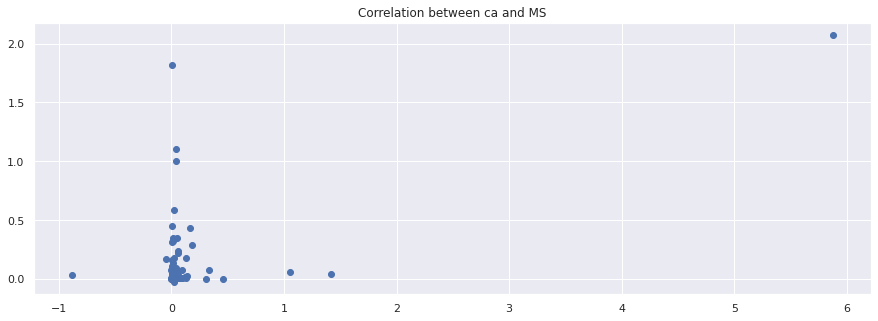



== Current State MO ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.008923653148684667
ca and MO have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5106701410004635
ca and MO have a MODERATE POS/NEGE correlation



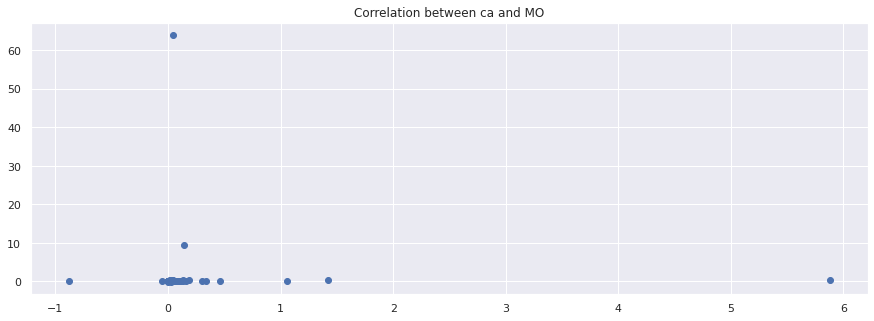



== Current State MT ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.37257100621437855
ca and MT have a MODERATE POSTIVE correlation


== Spearman Correlation Analysis ==

Spearman Correlation: 0.15712812711865765
ca and MT have a NEGLIGIBLE correlation



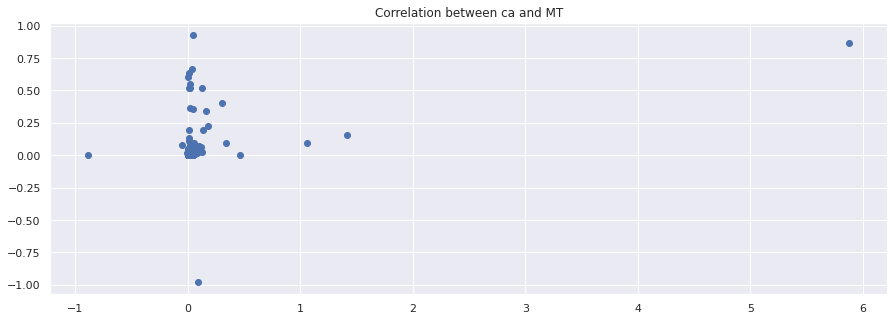



== Current State NE ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.25369756355158296
ca and NE have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5843179893613654
ca and NE have a MODERATE POS/NEGE correlation



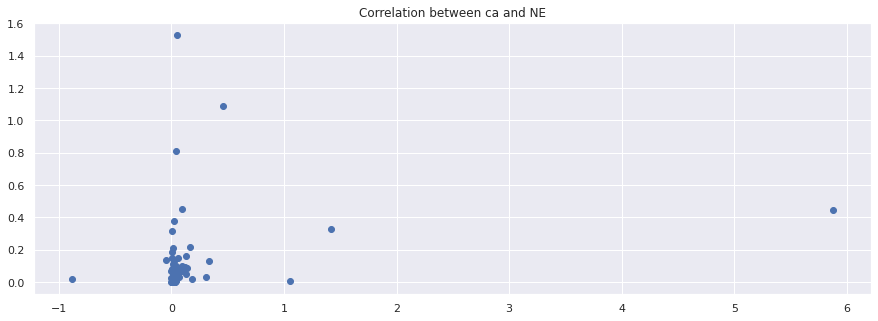



== Current State NV ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.015695579540017428
ca and NV have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.681011139783446
ca and NV have a MODERATE POS/NEGE correlation



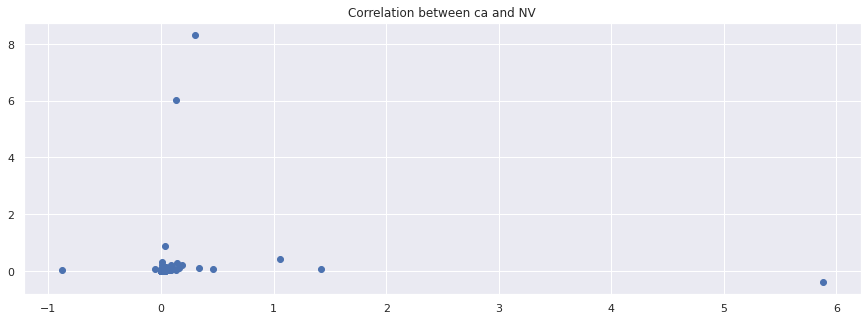



== Current State NH ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.21661567469623003
ca and NH have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5504133728446388
ca and NH have a MODERATE POS/NEGE correlation



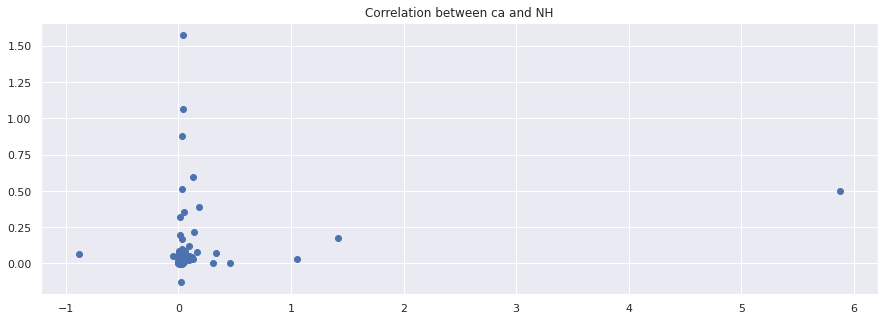



== Current State NJ ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.059765753939076315
ca and NJ have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5226325754446873
ca and NJ have a MODERATE POS/NEGE correlation



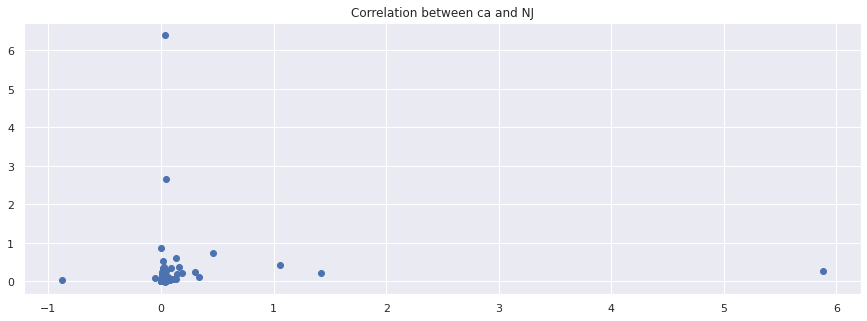



== Current State NM ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.27717576200355926
ca and NM have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5708725281489807
ca and NM have a MODERATE POS/NEGE correlation



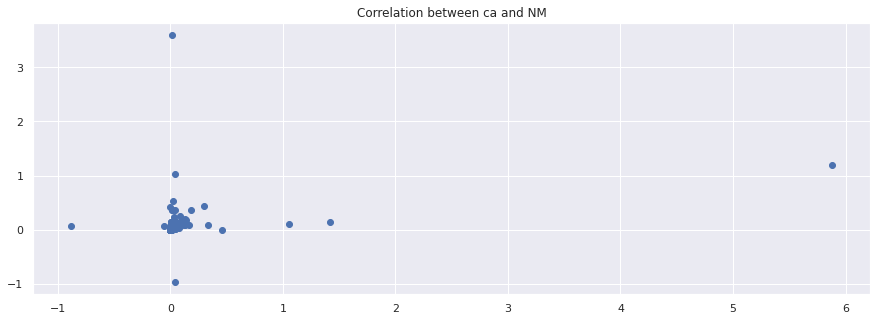



== Current State NY ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.2785012150688651
ca and NY have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.23369739409674523
ca and NY have a NEGLIGIBLE correlation



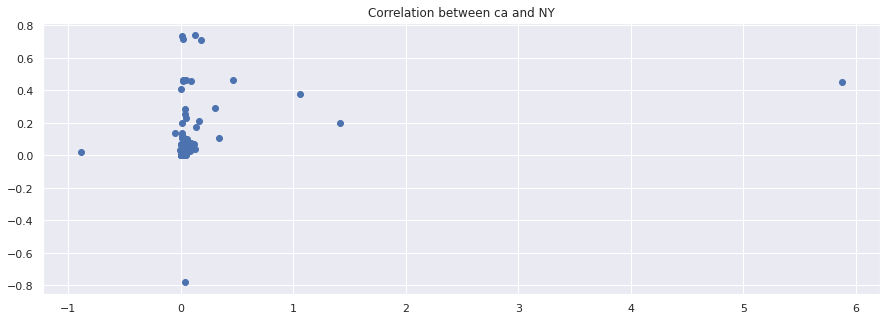



== Current State NC ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.01139546212490841
ca and NC have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6937951780948316
ca and NC have a MODERATE POS/NEGE correlation



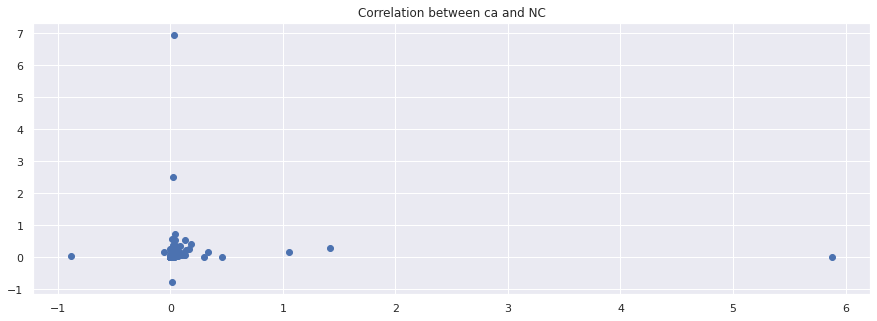



== Current State ND ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.1456710951270328
ca and ND have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5461695249626394
ca and ND have a MODERATE POS/NEGE correlation



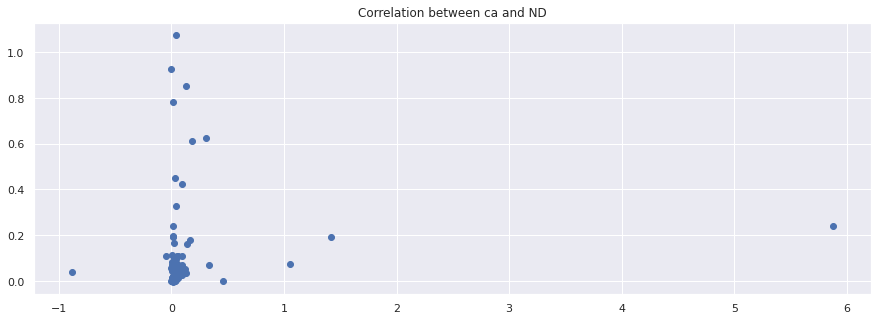



== Current State OH ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.06459539520769007
ca and OH have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6235874560196977
ca and OH have a MODERATE POS/NEGE correlation



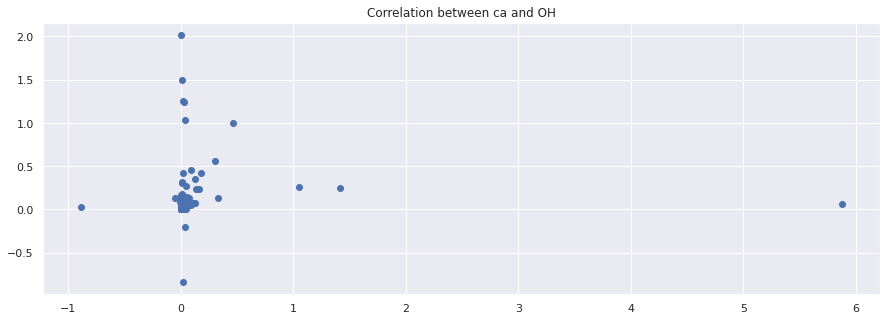



== Current State OK ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.05626869871377548
ca and OK have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.30052588018019677
ca and OK have a LOW POS/NEG correlation



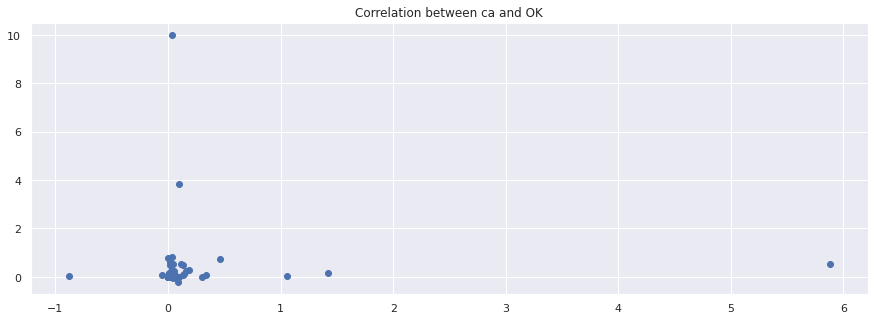



== Current State OR ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.22013300767323613
ca and OR have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6603346188398481
ca and OR have a MODERATE POS/NEGE correlation



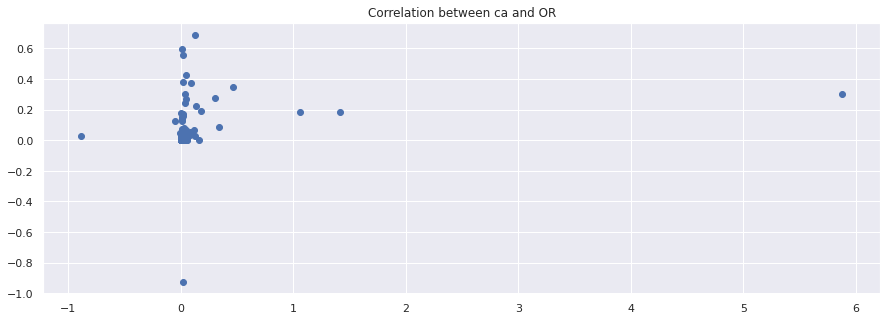



== Current State PA ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.1062051165147483
ca and PA have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6786891802273367
ca and PA have a MODERATE POS/NEGE correlation



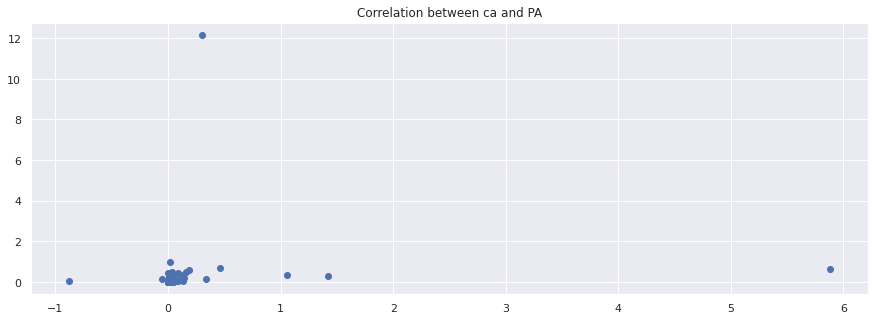



== Current State RI ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.32394041238205784
ca and RI have a MODERATE POSTIVE correlation


== Spearman Correlation Analysis ==

Spearman Correlation: 0.49009049473277294
ca and RI have a LOW POS/NEG correlation



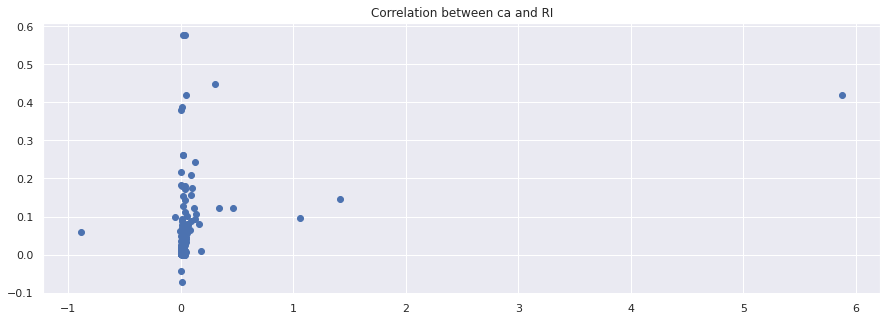



== Current State SC ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.2326767440800452
ca and SC have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.457480061094771
ca and SC have a LOW POS/NEG correlation



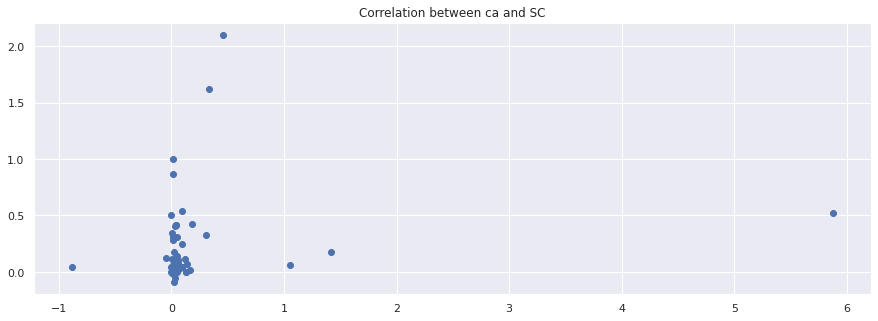



== Current State SD ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.17327361387533852
ca and SD have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.48114034771315023
ca and SD have a LOW POS/NEG correlation



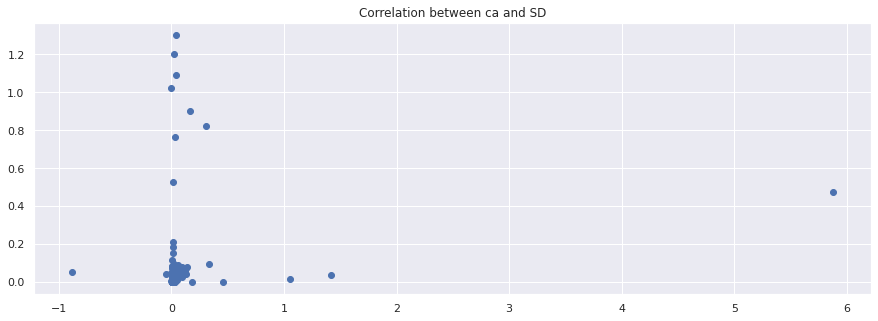



== Current State TN ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.12124763492045063
ca and TN have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6715321213720026
ca and TN have a MODERATE POS/NEGE correlation



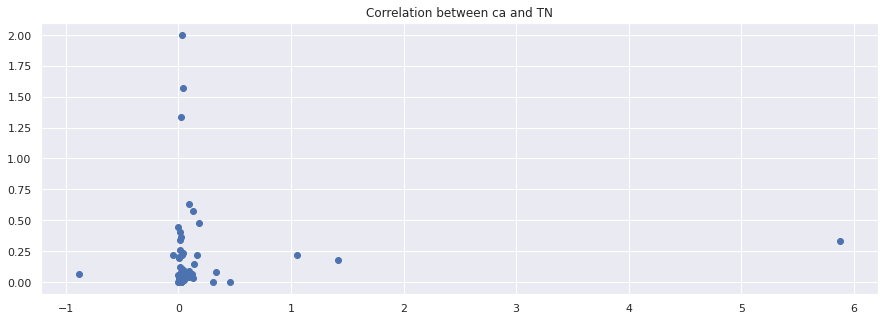



== Current State TX ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.07660736613145185
ca and TX have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.7220310980767825
ca and TX have a HIGH POS/NEG correlation



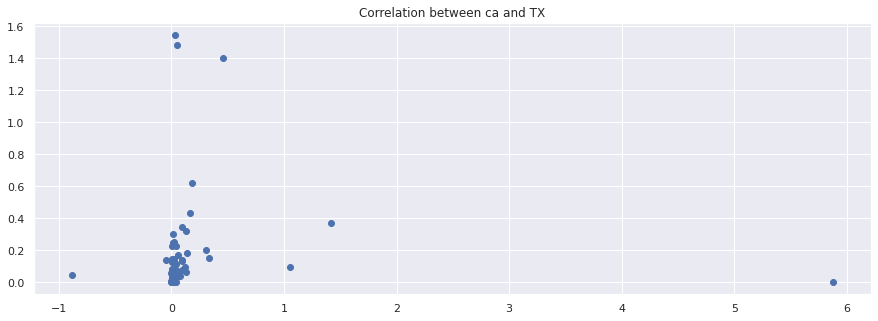



== Current State UT ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.2853143394758901
ca and UT have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6405032277804473
ca and UT have a MODERATE POS/NEGE correlation



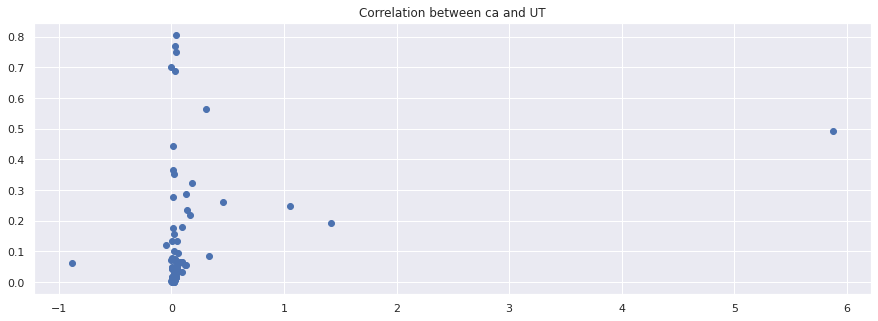



== Current State VT ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.2193467668811572
ca and VT have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6404692060579446
ca and VT have a MODERATE POS/NEGE correlation



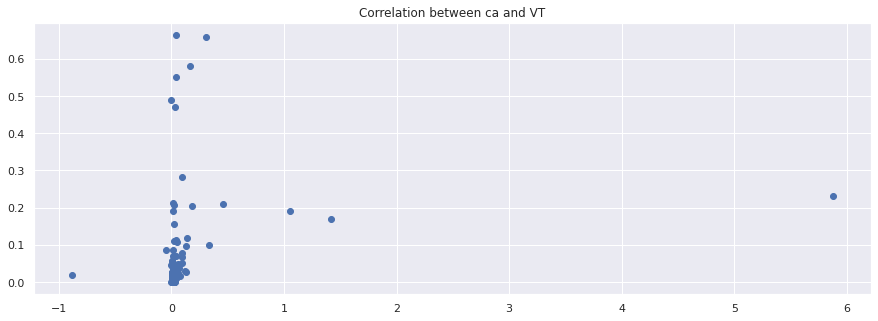



== Current State VA ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.14900377147942923
ca and VA have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.6772759725741045
ca and VA have a MODERATE POS/NEGE correlation



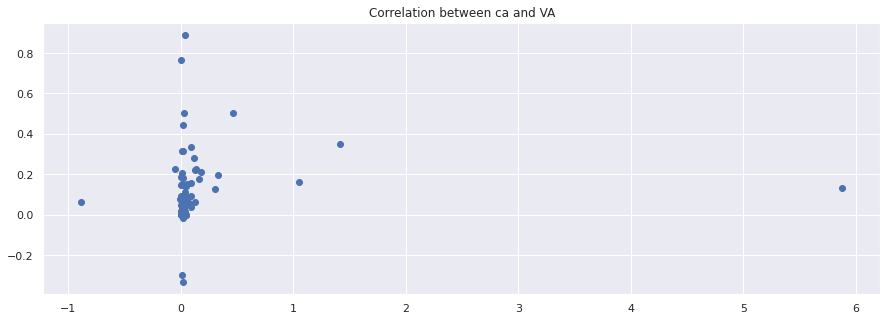



== Current State WA ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.1678623242978141
ca and WA have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.612154730976021
ca and WA have a MODERATE POS/NEGE correlation



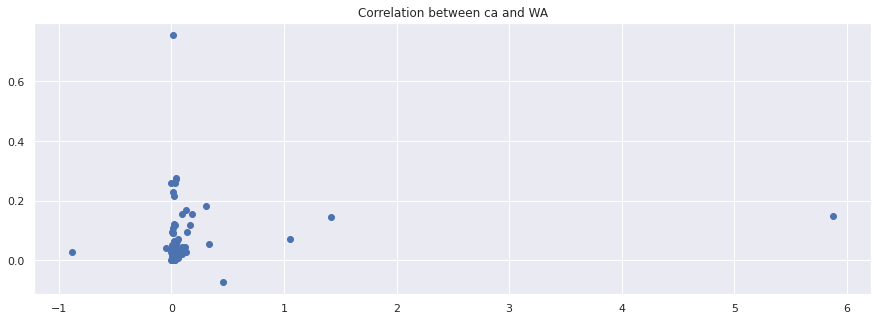



== Current State WV ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.514694025841408
ca and WV have a MODERATE POSTIVE correlation


== Spearman Correlation Analysis ==

Spearman Correlation: 0.36828445343529365
ca and WV have a LOW POS/NEG correlation



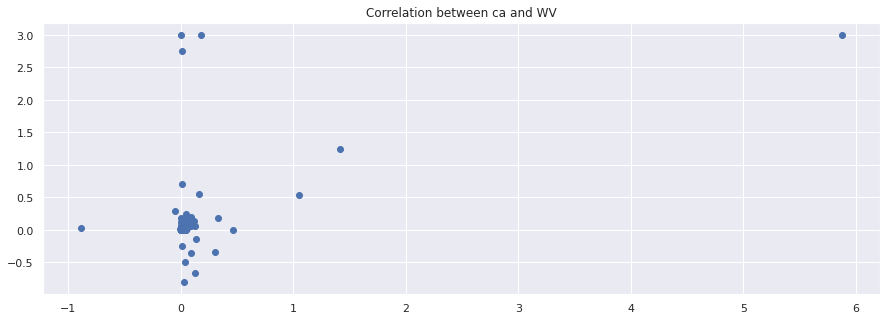



== Current State WI ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.2772113968250256
ca and WI have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.5799838776256397
ca and WI have a MODERATE POS/NEGE correlation



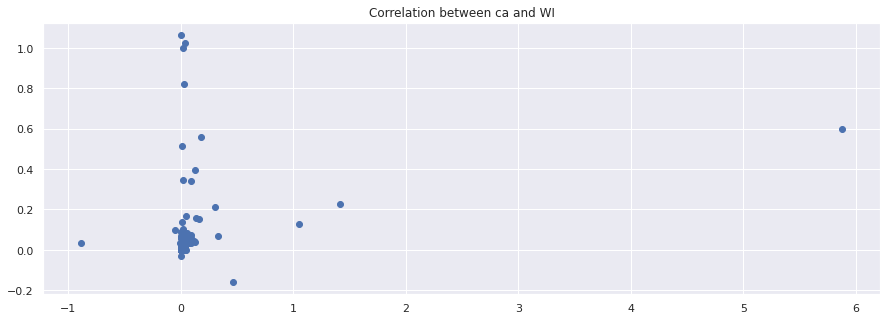



== Current State WY ==

== Pearson Correlation Analysis ==

Pearson Correlation: 0.00018248446474733134
ca and WY have a WEAK correlation

== Spearman Correlation Analysis ==

Spearman Correlation: 0.22252114058126368
ca and WY have a NEGLIGIBLE correlation



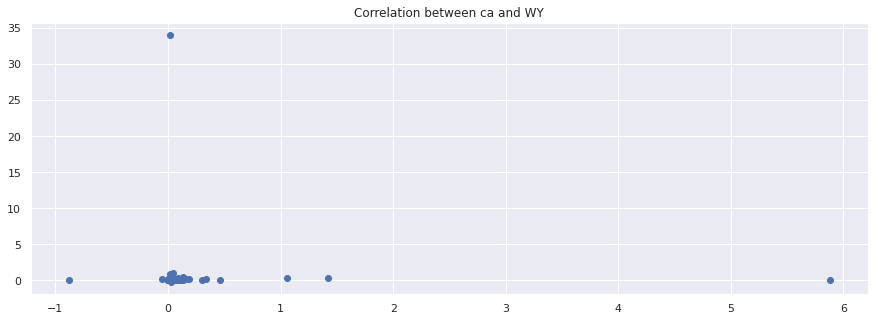

In [120]:
# loop through each state to find the best covariances
# for state in STATES:
#   dfState = getDataState(state)
#   print(dfState)
#   dfState['Percent Changes Cases'] = percentCasesChangeState(dfState['cases']) 
inputStateArray = np.array(dfInput['Percent Changes Cases'].to_list()) 
print("== Correlation Statistics with {} ==".format(STATE_INPUT))
results = {
    "AL": [], "AK": [], "AZ": [], "AR": [], "CA": [], "CO": [], "CT": [], "DC": [], 
    "DE": [], "FL": [], "GA": [], "HI": [], "ID": [], "IL": [], "IN": [], "IA": [], 
    "KS": [], "KY": [], "LA": [], "ME": [], "MD": [], "MA": [], "MI": [], "MN": [], 
    "MS": [], "MO": [], "MT": [], "NE": [], "NV": [], "NH": [], "NJ": [], "NM": [], 
    "NY": [], "NC": [], "ND": [], "OH": [], "OK": [], "OR": [], "PA": [], "RI": [], 
    "SC": [], "SD": [], "TN": [], "TX": [], "UT": [], "VT": [], "VA": [], "WA": [], 
    "WV": [], "WI": [], "WY": []
}

for state in STATES:
  print("\n\n== Current State {} ==".format(state))
  dfState = getDataState(state)
  dfState['Percent Changes Cases'] = dfState['total'].pct_change()
  dfState['Percent Changes Cases'] = dfState['Percent Changes Cases'].replace(np.nan, 0)
  dfState['Percent Changes Cases'] = dfState['Percent Changes Cases'].replace(np.inf, 0)
  newStateArray = np.array(dfState['Percent Changes Cases'].to_list())
  if (len(inputStateArray) > len(newStateArray)):
    inputStateArray = inputStateArray[(len(inputStateArray) - len(newStateArray)):]
  elif (len(inputStateArray) < len(newStateArray)):
    newStateArray = newStateArray[(len(newStateArray) - len(inputStateArray)):]

  correlationPearson, _ = pearsonr(inputStateArray, newStateArray)
  print("\n== Pearson Correlation Analysis ==")
  print("\nPearson Correlation: {}".format(correlationPearson))
  results[state].append(correlationPearson)

  if (-0.3 <= correlationPearson <= 0.3):
    print("{} and {} have a WEAK correlation".format(STATE_INPUT, state))
  elif (correlationPearson < -0.7):
    print("{} and {} have a STRONG NEGATIVE correlation\n".format(STATE_INPUT, state))
  elif (correlationPearson > 0.7):
    print("{} and {} have a STRONG POSITVE correlation\n".format(STATE_INPUT, state))
  elif (-0.7 <= correlationPearson <= -0.3):
    print("{} and {} have a MODERATE NEGATIVE correlation\n".format(STATE_INPUT, state))
  elif (0.3 <= correlationPearson <= 0.7):
    print("{} and {} have a MODERATE POSTIVE correlation\n".format(STATE_INPUT, state))
  else:
    print("inclusive.\n")


  print("\n== Spearman Correlation Analysis ==\n")
  correlationSpearman, _ = spearmanr(inputStateArray, newStateArray)
  print("Spearman Correlation: {}".format(correlationSpearman))
  results[state].append(correlationSpearman)

  if correlationSpearman < 0.3:
    print("{} and {} have a NEGLIGIBLE correlation\n".format(STATE_INPUT, state))
  elif 0.3 <= correlationSpearman < 0.5:
    print("{} and {} have a LOW POS/NEG correlation\n".format(STATE_INPUT, state))
  elif 0.5 <= correlationSpearman < 0.7:
    print("{} and {} have a MODERATE POS/NEGE correlation\n".format(STATE_INPUT, state))
  elif correlationSpearman >= 0.7:
    print("{} and {} have a HIGH POS/NEG correlation\n".format(STATE_INPUT, state))
  else:
    print("inclusive.\n")

  # plot graph
  plt.scatter(x=inputStateArray, y=newStateArray)
  trendlineFit = np.polyfit(inputStateArray, newStateArray, 1)
  plt.title("Correlation between {} and {}".format(STATE_INPUT, state))
  plt.grid(
    color='white', 
  )
  plt.show()